<a href="https://colab.research.google.com/github/tanvipabbathi1/NFLOnCrime/blob/main/NFLOnCrime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIS 5450 Final Project - NFL On Crime In Baltimore**

# Part 1: Introduction

From this project, we hope to understand drivers of crime in Baltimore in 2021. To accomplish this, we utilized 3 datasets.


1.   `crime_df`: contains information on the crimes that occured in 2021 in Baltimore. This includes neighborhood, crime type, date, etc.
2.   `ravens_schedule_df`: contains information on the Ravens game schedule in 2021
3.  `baltimore_neighborhood_gdf`: contains geographic locations of neighborhoods in Baltimore and population. Additionally, this dataframe contains information on the populations within different neighborhoods in Baltimore.

Aggregating these datasets, we can get an understanding on factors that drive crime rates in Baltimore, including location (relative to the stadium) and whether it is a game-day weekend. This can offer important insights into where Baltimore police could employ patrols on a given day, based on whether these factors are present.

When merging, we create the following dataframes as well:


1.   `crime_counts_df`: this is a df that stores the number of crimes that occurred by neighborhood, along with information about each neighborhood. We do this by merging an intermediate df which stores the number of crimes by neighborhood with the `baltimore_neighborhood_gdf`.
2.   `crime_during_season_df`: this is a dataframe that stores crime information specifically in the on-season time period for the Ravens. We will utilize this in our EDA and modelling to determine if there is a correlation between crime and the Ravens being in season.
3. `crime_on_game_days_df`: this is a dataframe that stores crime information, along with the result of the game each time the Ravens played. This is useful to help us determine factors that occured specifically on games where the Ravens were playing.
4. `crime_types_by_neighborhood_df`: this is a dataframe that contains each neighborhood and the breakdown of the types of crimes that occured within that neighborhood.



# Part 2: Imports, Data Loading & Pre-Processing

## 2.1: Imports

In this section, we are importing and installing the necessary libraries to complete the entire project, including pandas, matplotlib, scikitlearn, etc.

In [ ]:
pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=afdd39eb149958aa09dfb1149f5441aaf2ecacd16c19464507fd7a482d03d878
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandasql import sqldf
import seaborn as sns

## 2.2: Data Loading

### 2.2.1 Crime In Baltimore

To load `crime_df`, we utilized a Kaggle dataset containing data on Baltimore Crime in 2021. To access the dataset easily, we mount our drive and uploaded the kaggle JSON to save the dataset as a file in drive. We then accessed it through pandas.

The dataset is located at this [link](https://www.kaggle.com/datasets/ahmadrafiee/911-calls-for-service-metadata-1-million-record/data).


In [ ]:
#mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#create Kaggle directory
!mkdir -p ~/.kaggle

# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

#download the dataset
!kaggle datasets download -d ahmadrafiee/911-calls-for-service-metadata-1-million-record

Dataset URL: https://www.kaggle.com/datasets/ahmadrafiee/911-calls-for-service-metadata-1-million-record
License(s): CC-BY-SA-4.0
 92% 41.0M/44.5M [00:01<00:00, 42.0MB/s]
100% 44.5M/44.5M [00:01<00:00, 38.2MB/s]


In [ ]:
#Unzip the dataset
!unzip /content/911-calls-for-service-metadata-1-million-record.zip

Archive:  /content/911-calls-for-service-metadata-1-million-record.zip
  inflating: 911_Calls_for_Service.csv  


In [ ]:
#read and store the data. In the file, values are separated by tabs
crime_df = pd.read_csv("/content/911-calls-for-service-metadata-1-million-record.zip", sep = "\t")

### 2.2.2: Baltimore Ravens Schedule

To get the data on the Baltimore Ravens game schedule in 2021, we utilized Wikipedia, and leveraged pandas `read_html` function. The data is located in a table at this [link](https://en.wikipedia.org/wiki/2021_Baltimore_Ravens_season).

We scrape the table, which is the 8th table on the website, and store it in `ravens_schedule_df`.

In [ ]:
tables = pd.read_html ("https://en.wikipedia.org/wiki/2021_Baltimore_Ravens_season")
ravens_schedule_df = tables[8]

### 2.2.3: Baltimore Neighborhood Information

To get information on the location of neighborhoods in Baltimore, which we will utilize to visualize crime rates throughout the city, we uploaded the Baltimore Neighborhood Shapefile from the [Maryland government website](https://data.baltimorecity.gov/datasets/baltimore::neighborhood-1/explore).

For easy access, we uploaded this to drive as a public file, and then read the data from the generalized link. This is saved into `baltimore_neighborhood_gdf`.

In [ ]:
baltimore_neighborhood_gdf = gpd.read_file ("https://drive.google.com/uc?export=download&id=1qVKLUwehjFmoes8XH6lx1xCtzoEKsgsb")

## 2.3: Crime In Baltimore Pre-Processing

### 2.3.1: Drop Columns + Null Values

`crime_df` currently contains many columns which we aren't going to utilize in our analysis. Thus, we drop those columns (and provide justification for why) below:


1.   recordId: this column represents the id of the crime that occurred which was recorded by the police who were investigating. This doesn't predict anything regarding crime rates (as it is similar to an index, which can be utilized to identify certain crimes). As a result, we chose to drop this column, since we don't need another unique identified for each crime.
2.   NeedsSync: this column contains information on whether the technology across 2 devices is consistent and up to date. We don't utilize this in our analysis, as this isn't a value that could drive crime (as it is more of a situation than a driver). Thus, we have chosen to drop it from the cleaned dataframe.
3. callKey: this column contains another unique reference to the call number of the crime. Since this is unique to each crime that occurs, it cannot possibly be a driver of crime in Baltimore. Thus, we have chosen to remove it from the cleaned dataframe.
4. callNumber: this column contains the encrypted phone number of the person who called reporting the crime. This cannot possibly be a driver of crime in Baltimore, so we have chosen to not include it in our cleaned dataframe.
5. Census_Tracts: this column is the county that the crime was located given a unique numeric value. We already utilize the neighborhood in our analysis, so this information is repetitive. Thus, we remove this column from the cleaned dataset.
6. ESRI_OID: this column contains information regarding the GIS location of the crime. However, this information is repetitive, since we already take into account the neighborhood the crime occured in in our analysis. Thus, we remove this column from the cleaned dataset.

We store our cleaned dataframe in `crime_cleaned_df`.

In [ ]:
# dropping recordId, NeedsSync, callKey, callNumber, Census_Tracts, ERSI_OID
crime_cleaned_df = crime_df.drop (["recordId", "NeedsSync", "callKey", "callNumber", "Census_Tracts", "ESRI_OID"], axis = 1)

Additionally, we drop rows with null values, as we cannot process nulls in our analysis, and removing rows that contain any nulls shouldn't affect the overall results of our analysis.

In [ ]:
# drop nulls from cleaned dataframe
crime_cleaned_df.dropna().reset_index(drop = True)

,callDateTime,priority,district,description,incidentLocation,location,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,ZIPCode,Unnamed: 19


Other than that, we don't expect there to be any outliers in particular in our dataset, as our data doesn't contain numerical variables. Thus, we proceed to format other columns properly.

### 2.3.2: Formatting callDateTime

Since we will eventually want to merge `crime_cleaned_df` with `ravens_schedule_df` on the date, we wanted to ensure that the date format was consistent between both dataframes. Currently, the format for callDateTime is YYYY/MM/DD followed by the time. To keep the format consistent, we will extract only the YYYY/MM/DD, and keep this as a string datatype in our cleaned dataframe.

In [ ]:
# use regex to extract the YYYY/MM/DD from the current date
crime_cleaned_df["callDateTime"] = crime_cleaned_df["callDateTime"].str.extract("(\d{4}/\d{2}/\d{2}).*")

##2.4: Games in Baltimore Pre-Processing

### 2.4.1: Drop Columns

To start, we are going to drop the columns we won't utilize in our analysis.


1.   Week: this is essentially an index, as there is only one game played per week. Thus, it cannot be a determining variable in crime in Baltimore, so we remove it from our cleaned dataframe.
2.   Opponent: this column contains the name of the team the Ravens played in that week. Since it is a different team every week, this column wouldn't add any information regarding crime in Baltimore. Thus, we drop that column
3.  Record: this column contains the Ravens record, which essentially accumulates each week based on the result of the game. Thus, this column contains repetetitve data in terms of our analysis, so we remove it.
4. Recap: From Wikipedia, this is where the link to the recap of the game was attached, but we don't utilize the recaps in our analysis, so we can remove this column

We store this in `ravens_schedule_cleaned_df`.

In [ ]:
# dropping Week, Opponent and Record columns
ravens_schedule_cleaned_df = ravens_schedule_df.drop(["Week", "Opponent", "Record", "Recap"], axis = 1)

### 2.4.2: Formatting Date

Similar to `crime_cleaned_df`, we need to convert the date into a YYYY/MM/DD string format. Currently, the format is the month written out, followed by the date. This conversion will help us when merging the two dataframes together to complete our EDA and modelling.

To do this, we do the following:

1.   Create a dictionary called `month_names`, which contains a mapping from a month name as a string to its integer value
2.   Create a function `get_edited_date` which takes in the date as it is currently formatted in `ravens_schedule_df` and converts it into the proper YYYY/MM/DD format

In [ ]:
# Create a dictionary that maps a month name to the numeric value that we will utilize in
# the proper YYYY/MM/DD formatting
month_names = {
    "January": "01",
    "February": "02",
    "March": "03",
    "April": "04",
    "May": "05",
    "June": "06",
    "July": "07",
    "August": "08",
    "September": "09",
    "October": "10",
    "November": "11",
    "December": "12"
}

# function that takes in the date, and formats into YYYY/MM/DD format
def get_edited_date(date):
  #splits the date into parts by spaces
  #based on current format, would be a list as follows: [month name, numerical day]
  date_parts = date.split(" ")
  #if the month name is not a valid month, then the date should be none
  if month_names.get(date_parts[0]) == None:
    return None
  # if the day is between 1 and 9, then it should be formatting as 0X
  if len(date_parts[1]) == 1:
    date_parts[1] = "0" + date_parts[1]
  # Format the date to add the YYYY prior to the month number followed by the day
  if date_parts[0] != "January":
    return "2021/" + month_names.get(date_parts[0]) + "/" + date_parts[1]
  return "2022/" + month_names.get(date_parts[0]) + "/" + date_parts[1]


#apply the function to the dates in ravens_schedule_cleaned_df
ravens_schedule_cleaned_df["Date"] = ravens_schedule_cleaned_df["Date"].apply(get_edited_date)

### 2.4.3: Formatting Result

Since result is a binary variable that either contains win or loss, we convert this into 0s and 1s to help with our EDA and modelling. In this case, we format this column such that a 1 represents a win and a 0 represents a loss. To do this, we do the following:

1.   We create a function `get_win_loss`that outputs 1 if the result was a win and 0 if the result was a loss
2.   We apply the function to all the values in result



In [ ]:
# create a function that takes in result and outputs a 1 if it is a win and 0 if it is a loss
def get_win_loss(result):
  result = result.split()[0]
  if result == "L":
    return -1
  return 1

# Apply the function to all values in the dataframe
ravens_schedule_cleaned_df["Result"] = ravens_schedule_cleaned_df["Result"].apply(get_win_loss)

### 2.4.4: Formatting Venue

Since we are only worried about if the game played was home or away for our analysis of Baltimore crime, we can convert this into a binary variable such that a 1 represents the game was played at home, and a 0 represents it was played away:

1.   We create a function `get_home`that outputs 1 if the game was home and 0 if the game was away
2.   We apply the function to all the values in venue


In [ ]:
# define a function that returns 1 if the game was home and 0 if it was away
def get_home(venue):
  if venue == "M&T Bank Stadium":
    return 1
  return 0

# apply the function to all values of venue
ravens_schedule_cleaned_df["Venue"] = ravens_schedule_cleaned_df["Venue"].apply(get_home)

### 2.4.5: Drop Nulls

Currently, we have a row representing the bye week. We don't want to utilize this in our analysis since it is inconsistent with the rest of the data (as it is a weekend within the season in which the Ravens didn't play at all). Thus, to avoid any imprecision within our analysis, we chose to just remove it from our analysis by dropping the nulls.

In [ ]:
ravens_schedule_cleaned_df.dropna().reset_index(drop = True)

,Date,Result,Venue
0,2021/09/13,-1,0
1,2021/09/19,1,1
2,2021/09/26,1,0
3,2021/10/03,1,0
4,2021/10/11,1,1
5,2021/10/17,1,1
6,2021/10/24,-1,1
7,2021/11/07,1,1
8,2021/11/11,-1,0
9,2021/11/21,1,0


## 2.5: Baltimore Neighborhood Information Pre-Processing

### 2.5.1: Drop Columns + Null Values

To start, we remove columns we won't utilize in our analysis.

1.   OBJECTID: This column is anther indexing column which is unique to each neighborhood. This wouldn't be helpful in being one of the drivers of crime, so we remove it from the cleaned dataframe.
2.   Shape__Area, Shape__Length: The information regarding the shape of the neighborhood (which is used in creating maps) is already contains in the geometry column, so this information is repetitive. Thus, we remove it.

We save the cleaned dataframe in `baltimore_neighborhood_cleaned_gdf`.

In [ ]:
# drop OBJECTID, Shape_Area and Shape_Length
baltimore_neighborhood_cleaned_gdf = baltimore_neighborhood_gdf.drop (["OBJECTID", "Shape__Area", "Shape__Length"], axis = 1)

Next, we drop any null values. Since we utilize all the values in our analysis, having nulls wouldn't allow us to take in all the information for a specific neighrbood, which would affect our modelling negatively. Thus, we chose to drop them. We also reset the index since we are removing rows.

In [ ]:
# drop the nulls and reset the index
baltimore_neighborhood_cleaned_gdf.dropna().reset_index (drop = True)

,Name,Population,White,Blk_AfAm,AmInd_AkNa,Asian,NatHaw_Pac,Other_Race,TwoOrMore,Hisp_Lat,Housing,Occupied,Vacant,geometry
0,Beechfield,4013,462,3191,3,108,0,105,144,164,1721,1592,129,"POLYGON Z ((-76.69691 39.28134 0.00000, -76.69..."
1,Belair-Parkside,449,91,302,2,12,0,4,38,17,174,152,22,"POLYGON Z ((-76.56721 39.32916 0.00000, -76.56..."
2,Curtis Bay Industrial Area,20,6,8,0,0,0,6,0,4,1,1,0,"POLYGON Z ((-76.58727 39.22997 0.00000, -76.58..."
3,Eastwood,764,314,81,4,7,0,301,57,377,286,272,14,"POLYGON Z ((-76.52981 39.29275 0.00000, -76.52..."
4,Forest Park Golf Course,358,14,305,5,2,0,27,5,13,135,123,12,"POLYGON Z ((-76.69324 39.32261 0.00000, -76.69..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,Spring Garden Industrial Area,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-76.61640 39.26693 0.00000, -76.61..."
275,Locust Point,3709,3124,137,8,167,2,47,224,177,2084,1893,191,"POLYGON Z ((-76.59048 39.27188 0.00000, -76.59..."
276,Locust Point Industrial Area,96,63,8,1,7,0,0,17,9,34,21,13,"POLYGON Z ((-76.59433 39.27524 0.00000, -76.59..."
277,Jones Falls Area,179,136,17,0,5,0,0,21,3,114,108,6,"POLYGON Z ((-76.64113 39.32749 0.00000, -76.64..."


### 2.5.2: Determine Distance Of A Neighborhood From Stadium

To start, we need to determine the geometry of the stadium, so we can utilize this to determine the distance of each neighborhood relative to the stadium. This could possibly be a driver of crime, so it is important we take this into account in our modelling.

The stadium is stored within baltimore_neighborhood_cleaned_gdf as "Stadium/Entertainment Area", so we extract the geometry of this row from the dataframe and store it as `stadium_geometry`.

In [ ]:
# extract "Stadium/Entertainment Area" from baltimore_neighborhood_cleaned_gdf and store it in stadium_geometry
stadium_geometry = baltimore_neighborhood_cleaned_gdf[baltimore_neighborhood_cleaned_gdf["Name"] == "Stadium/Entertainment Area"]['geometry'].iloc[0]

Next, we must add a column to `baltimore_neighborhood_cleaned_gdf` that stores the distance from that neighborhood to the stadium.


1.   We create a function `determine_distance` that calculates the distance from a given locatin to the stadium, which we have stored as `stadium_geometry`.
2.   We apply this function to all the neighborhoods in `baltimore_neighborhood_cleaned_gdf` and store the value in a new column called "Distance".


In [ ]:
# create a function that calculates the distance from a given location to the stadium
def determine_distance(location):
  return location.distance(stadium_geometry)

# apply the function to all neighborhoods and store the individual values in Distance column
baltimore_neighborhood_cleaned_gdf["Distance"] = baltimore_neighborhood_cleaned_gdf["geometry"].apply(determine_distance)

## 2.6: Joins

For our analysis and modelling, we would like to explore some relations that require the merging of 2 of our current dataframes. We utilize this section to create these dataframes.

### 2.6.1: Crime Counts By Neighborhood

To create heat maps of where crime occurs the most heavily and to determine if there is a correlation between neighborhoods and crime, we create a df `crime_counts_by_neighborhood_df`. To create this, we do the following:

1.   Aggregate crimes by neighborhood in `crime_cleaned_df`
2.   Merge this with `baltimore_neighborhood_cleaned_gdf` on neighborhood column


In [ ]:
# Store the count of each neighborhood in crime_counts_df and reset the index
crime_counts_df = crime_cleaned_df.groupby('Neighborhood').size().reset_index(name='crime_count')

# do a merge with baltimore_neighborhood_cleaned_gdf on the neighborhood column (called "Name" in baltimore_neighborhood_cleaned_gdf)
crime_counts_df = baltimore_neighborhood_cleaned_gdf.merge(crime_counts_df, left_on='Name', right_on='Neighborhood', how='left')

# if there were any unmatched neighborhoods, we just fill them with 0s
crime_counts_df['crime_count'].fillna(0, inplace=True)

### 2.6.2: Game Day Crime

Next, we wanted a dataframe which contained information on crime specifically on days the Ravens had a game, along with information on the result of the game on these particular days. To do this, we create 2 dataframes that will both be useful in our modelling and analysis.
1.   `crime_during_season_df`: this dataframe contains all crime that occured in Baltimore during the on-season months for the Baltimore Ravens (ie. September - December 2021 and January 2022). This will be useful when we want to make comparisons on in-season vs out-of-season crime rates, along with analysis specifically during the football season. To do this, we extract only rows with a "callDateTime" that begins with the proper format.
2.   `crime_on_game_days_df`: With `crime_during_season_df`, we perform a merge with `ravens_schedule_cleaned_df` to only keep crime that occured specifically on game days. We perform a right merge, so only crime that occured on the actual game days is kept. If there was no crime on a particular game day, it would still be included in the dataframe.

In [ ]:
#creates a new df which only keeps crime that occured within the on-season
crime_during_season_df = crime_cleaned_df[(crime_cleaned_df["callDateTime"].str.contains("2021/09")) |
 (crime_cleaned_df["callDateTime"].str.contains("2021/09")) |
 (crime_cleaned_df["callDateTime"].str.contains("2021/10")) |
 (crime_cleaned_df["callDateTime"].str.contains("2021/11")) |
 (crime_cleaned_df["callDateTime"].str.contains("2021/12")) |
 (crime_cleaned_df["callDateTime"].str.contains("2022/01"))]

#right joins this df with ravens_schedule, to create a new df with crime only on game days
crime_on_game_days_df = crime_during_season_df.merge(ravens_schedule_cleaned_df, left_on="callDateTime", right_on="Date", how="right")

### 2.6.3: Crime Type and Count By Neighborhood

We were also curious to see how crime broke down in each neighborhood by type. This would be interesting to determine if there was a specific crime type that was most prominent.

To do this, we grouped `crime_cleaned_df` by neighborhood, then by description to count the descriptions per neighborhood. We store this in `crime_types_by_neighborhood`.

In [ ]:
# count number of each description by neighborhood
crime_types_by_neighborhood_df = crime_cleaned_df.groupby("Neighborhood")["description"].value_counts()
crime_types_by_neighborhood_df = crime_types_by_neighborhood_df.reset_index(name = "count")
crime_types_by_neighborhood_df

,Neighborhood,description,count
0,Abell,DISORDERLY,420
1,Abell,AUTO ACCIDENT,142
2,Abell,Business Check,105
3,Abell,COMMON ASSAULT,100
4,Abell,911/NO VOICE,93
...,...,...,...
41762,York-Homeland,Business Check,1
41763,York-Homeland,Repo,1
41764,York-Homeland,CHECK WEBEING,1
41765,York-Homeland,CHECK WELL BEIN,1


# Part 3: Summary Statistics, Counts & Descriptions

Next, we wanted to look at summary statistics and the datatypes in our dataframes to help determine correlations and features we would like to analyze in our EDA.

## 3.1: Crime In Baltimore

First, we wanted to look at the datatypes within the `crime_cleaned_df` just to get a general sense of the data we are working with.

In [ ]:
# get datatypes of columns
crime_cleaned_df.dtypes

callDateTime                    object
priority                        object
district                        object
description                     object
incidentLocation                object
location                        object
Neighborhood                    object
PoliceDistrict                  object
PolicePost                     float64
CouncilDistrict                float64
SheriffDistricts                object
Community_Statistical_Areas     object
ZIPCode                        float64
Unnamed: 19                    float64
dtype: object

In [ ]:
crime_cleaned_df.head(10)

,callDateTime,priority,district,description,incidentLocation,location,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,ZIPCode,Unnamed: 19
0,2021/01/04,Low,TRU,HIT AND RUN,3500 AILSA AV,3500 AILSA AV BALTIMORE MD,Waltherson,Northeastern,426.0,2.0,D4,Lauraville,21214.0,NaN
1,2021/01/04,Medium,WD,NARCOTICS,1700 N CALHOUN ST,1700 N CALHOUN ST BALTIMORE MD,Sandtown-Winchester,Western,742.0,7.0,D9,Sandtown-Winchester/Harlem Park,21217.0,NaN
2,2021/01/04,Low,CD,OTHER,2000 DRUID HILL AV,2000 DRUID HILL AV BALTIMORE MD,Druid Heights,Central,131.0,11.0,D8,Upton/Druid Heights,21217.0,NaN
3,2021/01/04,Medium,SD,NARCOTICS,600 S PAYSON ST,600 S PAYSON ST BALTIMORE MD,Carrollton Ridge,Southern,934.0,9.0,D8,Southwest Baltimore,21223.0,NaN
4,2021/01/05,Low,TRU,DESTRUCT PROP,3600 CHESTERFIELD AV,3600 CHESTERFIELD AV BALTIMORE MD,Belair-Edison,Northeastern,432.0,13.0,D6,Belair-Edison,21213.0,NaN
5,2021/01/05,Low,SW,HIT AND RUN,3400 DULANY ST,3400 DULANY ST BALTIMORE MD,Saint Agnes,Southwestern,832.0,10.0,D10,Morrell Park/Violetville,21229.0,NaN
6,2021/01/05,Low,NE,AUTO ACCIDENT,MORAVIA RD/BOWLEYS LN,MORAVIA RD and BOWLEYS LN BALTIMORE MD,Pulaski Industrial Area,Northeastern,441.0,2.0,D6,Claremont/Armistead,21206.0,NaN
7,2021/01/05,Low,TRU,LARCENY F/AUTO,1400 HULL ST,1400 HULL ST BALTIMORE MD,Locust Point,Southern,943.0,11.0,D7,South Baltimore,21230.0,NaN
8,2021/01/05,Low,TRU,LARCENY F/AUTO,4700 MELBOURNE RD,4700 MELBOURNE RD BALTIMORE MD,Beechfield,Southwestern,833.0,8.0,D10,Beechfield/Ten Hills/West Hills,21229.0,NaN
9,2021/01/06,Non-Emergency,ND,LOUD MUSIC,3300 FRISBY ST,3300 FRISBY ST BALTIMORE MD,Waverly,Northern,543.0,14.0,D2,The Waverlies,21218.0,NaN


Looking at the top couple of rows, it is clear that neighborhood and description have repeated values, so these could possibly be categorical variables in our EDA and modelling. To get a further understanding of these 2 columns, we wanted to determine the unique values, so we could possibly see if there are any correlations in terms of crime count based on the categories (if they exist). Thus, we found the unique values in each column.

In [ ]:
# find unique values of description in df
print(list(crime_cleaned_df["description"].unique()))

['HIT AND RUN', 'NARCOTICS', 'OTHER', 'DESTRUCT PROP', 'AUTO ACCIDENT', 'LARCENY F/AUTO', 'LOUD MUSIC', 'SUPV COMPLAINT', 'FALSE PRETENSE', 'WELL CHECK', 'Repo', 'NONBREATHING / A', 'ESCORTOTHER', 'LARCENY', 'INVESTIGATE', 'UNFOUNDED', 'FAMILY DISTURB', 'ESCORT', 'DISORDERLY', 'AUTO THEFT', 'BURGLARY', 'Private Tow', 'SQUEEGEE DIST', 'SICK CASE', 'NOTIFY', 'INVESTIGATE AUTO', 'RECOVER PROPERTY', 'SUSPICIOUS PERS', 'IVESTIGATE', 'LOST MEDS', 'PROSTITUTION', 'DISPUTE', 'MISSING PERSON', 'COMMON ASSAULT', 'RECOVERED VEH', 'LOST PROPERTY', 'INVESTIGETE', 'WANTED ON WARR', 'ASSISTANCE', 'FOLLOW UP', 'INTOXICATED PERS', 'ILLEGAL DUMPING', 'LEWD ACT', 'ESCORET', 'TOWED VEHICLE', 'PANHANDLER', 'WEE CHECK', 'DEATH REPORT', 'AUDIBLE ALARM', 'INVESTIGAE', 'UNAUTHORIZED USE', 'OTESCORT', 'FIRE', 'AUTO ACC/INJURY', 'ROBBERY ARMED', 'VERIFY PATIENT', 'VERIFY', 'DISCHRG FIREARM', 'NOTIFIY', 'BEHAVIOR CRISIS', 'Tow - DO NOT USE', 'VEHICLE DISTURB', 'INJURED PERSON', 'EXPART/PROT/PEAC', 'INVESTYIGATE',

From this, it is clear that there were many different crime types in Baltimore in 2021. However, in our EDA, we could look into the crime counts of different crimes and see which types were the most popular. Additionally, we could see if there was a correlation between crime type and neighborhood.

Next, we look at the unique values of neighborhood.

In [ ]:
# find unique values of neighborhood in df
print(list(crime_cleaned_df["Neighborhood"].unique()))

['Waltherson', 'Sandtown-Winchester', 'Druid Heights', 'Carrollton Ridge', 'Belair-Edison', 'Saint Agnes', 'Pulaski Industrial Area', 'Locust Point', 'Beechfield', 'Waverly', 'Greenmount West', 'Riverside', 'Arlington', 'Lakeland', 'New Northwood', 'Bayview', 'Frankford', 'Greektown', 'Charles Village', 'Otterbein', 'Medfield', 'Homeland', 'Mount Vernon', 'Bridgeview/Greenlawn', 'Downtown', 'Parklane', 'Mount Washington', 'Hampden', 'Oldtown', 'Inner Harbor', 'Tremont', 'University Of Maryland', 'Cherry Hill', 'Hanlon-Longwood', 'Broening Manor', 'Canton', 'CARE', 'Perring Loch', 'Park Circle', 'Fells Point', 'Brooklyn', 'Old Goucher', 'Curtis Bay', 'Guilford', 'Patterson Place', 'Fairfield Area', 'Upper Fells Point', 'Loch Raven', 'Mondawmin', 'Sharp-Leadenhall', 'Kernewood', 'Patterson Park Neighborhood', 'Pleasant View Gardens', 'New Southwest/Mount Clare', 'Port Covington', 'Cameron Village', 'Franklin Square', 'Millhill', 'Rognel Heights', 'South Baltimore', 'Spring Garden Industr

From this, we can see that the Neighborhood column also has a limited number of unique values, so it is another categorical variable we can utilize in our analysis and modelling. Additionally, since we have `baltimore_neighborhood_cleaned_gdf`, we want to see if there are any neighborhoods in `crime_cleaned_df` that aren't in `baltimore_neighborhood_cleaned_gdf`. This means we won't have information on these neighborhoods similar to the other ones.

Since this is a left anti-join, we utilize SQL in this section, as the query is more direct than utilizing pandas.

To run the SQL query, the datatype of "geometry" is not supported by SQL. However, it is still very important for the remaining EDA we will perform. Thus we create an intermediate dataframe, `neighborhoods_dropped_gdf` that doesn't contain the "geometry" column, so we can perform our query.

In [ ]:
# create intermediate query that doesn't contain the "geometry" column
neighborhoods_dropped_gdf = baltimore_neighborhood_cleaned_gdf.drop (["geometry"], axis = 1)

In [ ]:
# SQL query to only get distinct columns in crime_cleaned_df that aren't in neighborhoods_dropped_gdf
sqlquery = '''
SELECT DISTINCT crime_cleaned_df.Neighborhood
FROM crime_cleaned_df
LEFT JOIN neighborhoods_dropped_gdf ON crime_cleaned_df.Neighborhood = neighborhoods_dropped_gdf.Name
WHERE neighborhoods_dropped_gdf.Name IS NULL
'''

# execute the query and store as pandas df
neighborhoods_only_in_crime_cleaned_df = sqldf(sqlquery, locals())
neighborhoods_only_in_crime_cleaned_df

,Neighborhood
0,New Southwest/Mount Clare
1,Port Covington
2,Lower Edmondson Village
3,Glenham-Belhar
4,Parkview/Woodbrook
5,Butcher's Hill
6,Concerned Citizens Of Forest Park
7,Burleith-Leighton
8,Perkins Homes
9,Stadium Area


From this, we can see that there are a few neighborhoods in our `crime_cleaned_df` that aren't contained in `baltimore_neighborhood_cleaned_gdf`. Additionally, we see that there are some rows with "nan" as their neighborhood. These likely weren't dropped prior since nan was stored as a string without proper capitalization.

We choose not to remove these values from `crime_cleaned_df` since they are still valuable pieces of information to have.

## 3.2: Counts By Neighborhood

Next, we wanted to see the summary statistics of `crime_counts_df` to get an understanding of our data grouped by each Neighborhood.

In [ ]:
# describes the crime_counts_df numeric variables
crime_counts_df.describe()

,Population,White,Blk_AfAm,AmInd_AkNa,Asian,NatHaw_Pac,Other_Race,TwoOrMore,Hisp_Lat,Housing,Occupied,Vacant,Distance,crime_count
count,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,2099.311828,584.322581,1213.182796,8.286738,76.021505,0.666667,100.523297,116.308244,164.612903,1051.071685,901.358423,149.713262,0.048360,3667.204301
std,2251.930163,1114.305557,1612.557886,13.304278,206.009585,1.354449,250.990022,143.496190,352.196480,1157.869186,1023.819735,166.564385,0.026551,4324.329257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,719.000000,39.000000,219.000000,1.000000,4.000000,0.000000,12.000000,34.000000,23.000000,335.500000,303.500000,35.000000,0.026945,1113.500000
50%,1339.000000,139.000000,866.000000,4.000000,13.000000,0.000000,26.000000,64.000000,50.000000,701.000000,601.000000,98.000000,0.050046,2517.000000
75%,2677.500000,562.500000,1634.500000,9.000000,55.500000,1.000000,63.500000,134.500000,140.000000,1314.000000,1105.500000,198.500000,0.068390,4605.500000
max,17135.000000,10409.000000,14596.000000,90.000000,2094.000000,9.000000,1927.000000,957.000000,2636.000000,7848.000000,7226.000000,928.000000,0.117053,41092.000000


This is interesting, as we can see that on average, over the year 2021, each neighborhood had about 3667 crimes occur. However, the standard deviation is quite large, meaning that our data is very scattered. Additionally, the max is incredibly high, with a neighborhood having approximately 40,000 crimes occur within the year. It will be interested to explore this neighborhood relative to the others in our EDA.

# Part 4: Exploratory Data Analysis

## 4.1: Crime By Neighborhood

### 4.1.1: Histogram of Number of Crimes For Top 5 Neighborhoods

To start, based on the summary statistics of `crime_counts_df`, we were curious to see the crime count for the top 5 neighborhoods in the dataframe, and see how they compare to the mean number of crimes per neighborhood. This could be valuable to intuitely determine if neighborhood is a driving factor of crime rates in Baltimore.

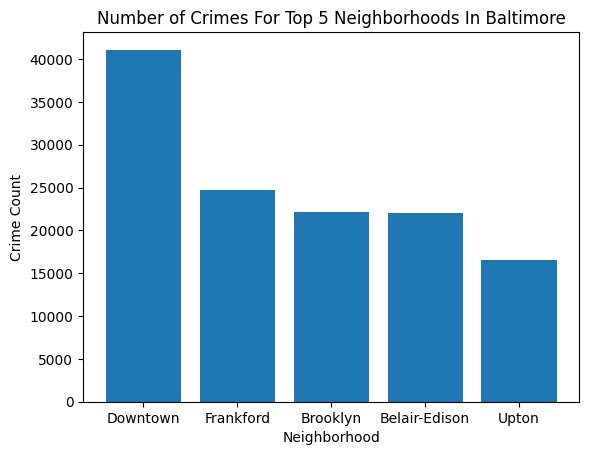

In [ ]:
# extract the top 5 neighborhoods with highest crime count
top_5_neighborhoods_df = crime_counts_df.sort_values (by = "crime_count", ascending = False)
top_5_neighborhoods_df = top_5_neighborhoods_df.head(5)

# plot these neighborhoods and their counts as a bar chart
plt.bar(top_5_neighborhoods_df ["Neighborhood"], top_5_neighborhoods_df["crime_count"])
plt.title("Number of Crimes For Top 5 Neighborhoods In Baltimore")
plt.xlabel("Neighborhood")
plt.ylabel("Crime Count")

plt.show()

From this chart, there are a few things to note:

*   Downtown: This neighborhood has the highest crime (significantly) compared to the other neighborhoods in Baltimore. Additionally, this neighborhood likely increased both the standard deviation and mean for neighborhood crime count found in the previous section. For Baltimore police, this likely means that more should be stationed around the Downtown area, since crime rates are significantly higher there than any other neighborhood.
*   The remaining 4 neighborhoods have very high crime rates compared to the average as well (the mean was around 3600). This also indicates that the crime in Baltimore was very scattered (which explains the very large standard deviation). For the remaining top 4 neighborhoods, it appears as though crime count sits at around 20,000 over the year.  



### 4.1.2: Breakdown of Top 5 Neighborhood Crimes By Type

For these neighborhoods, we were curious in seeing if there was a specific type of crime that came out to be most prominent. To do this, we represent the crime types as a stacked bar chart. Note that, as we found in our analysis of the the "description" column, there were many different types of crimes. Thus, we will stack the top 5 in the chart, and store the rest in the "other" section.

We utilize `crime_types_by_neighborhood_df` to get the top 5 neighborhoods and chart the types of crimes that occur.

In [ ]:
# list of top 5 neighborhoods which we will extract from
top_5_neighborhoods = ["Downtown", "Frankford", "Brooklyn", "Belair-Edison", "Upton"]

#Extract the top 5 neighborhoods from crime_types_by_neighborhood_df and store them
crime_breakdown_top_5_df = crime_types_by_neighborhood_df[crime_types_by_neighborhood_df ["Neighborhood"].isin(top_5_neighborhoods)].reset_index (drop = True)

#Create a new df in which we will store the top 5 descriptions, along with the other category, for each of the neighborhoods
breakdown_df = pd.DataFrame()

#Loop through all the neighborhoods in the breakdown of top 5 neighborhoods
for neighborhood, description in crime_breakdown_top_5_df.groupby("Neighborhood"):
  #get the top 5 descriptions from each neighborhood, and then count the number of descriptions that aren't in the top 5
  top_5_descriptions = description.nlargest(5, "count")
  other_count = description["count"].sum() - top_5_descriptions["count"].sum()

  #create a new df to store the other descriptions and their counts and add this to the df with top 5 descriptions
  other_df = pd.DataFrame({"Neighborhood": neighborhood, "description": "Other", "count": other_count}, index = [0])
  top_5_descriptions = pd.concat ([top_5_descriptions, other_df])

  #add this to our overall df with the breakdown of each of the description counts for the top 5
  breakdown_df = pd.concat([breakdown_df, top_5_descriptions]).reset_index(drop = True)

#switch the format such that we index by neighborhood, and each column represents the count of each of the descriptions
pivot_df = breakdown_df.pivot(index = "Neighborhood", columns = "description", values = "count")
#if one neighborhood didn't have a specific description in the top 5 descriptions, fill it with 0s
pivot_df = pivot_df.fillna(0)

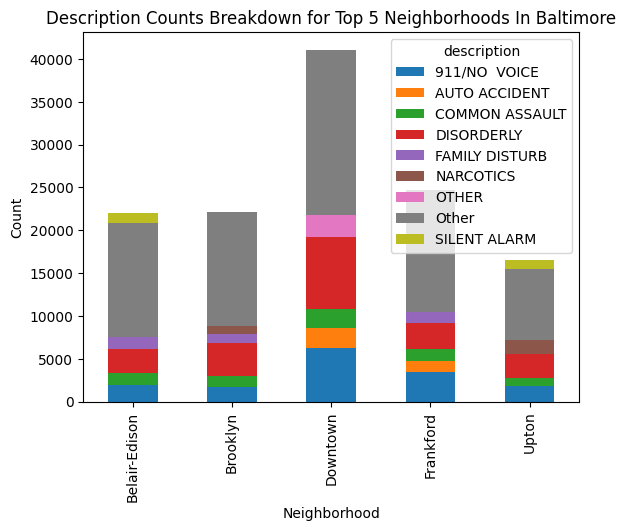

In [ ]:
#plot this as a stacked bar chart
pivot_df.plot (kind = "bar", stacked = True)
plt.title("Description Counts Breakdown for Top 5 Neighborhoods In Baltimore")
plt.xlabel ("Neighborhood")
plt.ylabel("Count")
plt.show()

This chart gives us some valuable insights into the types of crimes that are occuring in Baltimore.
*   Disorderly: This type of crime takes up a good amount in all 5 of the top neighborhoods, making it a very consistent type of crime, at least from preliminary analysis. Thus, this could imply that there is violence in Baltimore, that accounts for a fairly large amount of its total crime.
*   Other: For all of the top 5 neighborhoods, the other category makes up the majority of the crime types. This means that this is strongly fragmented, as there are many crime types that are occuring within each neighborhood.


### 4.1.3: Baltimore Crime Mapped By Neighborhood

Additionally, we were curious to see the frequency of crimes by neighborhood mapped out visually. To do this, we utilized the `baltimore_neighborhood_cleaned_gdf` to get the data on the shape of each neighborhood to build the map.

<ipython-input-34-e9e9926f452e>:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stadium_point = stadium_geometry.centroid


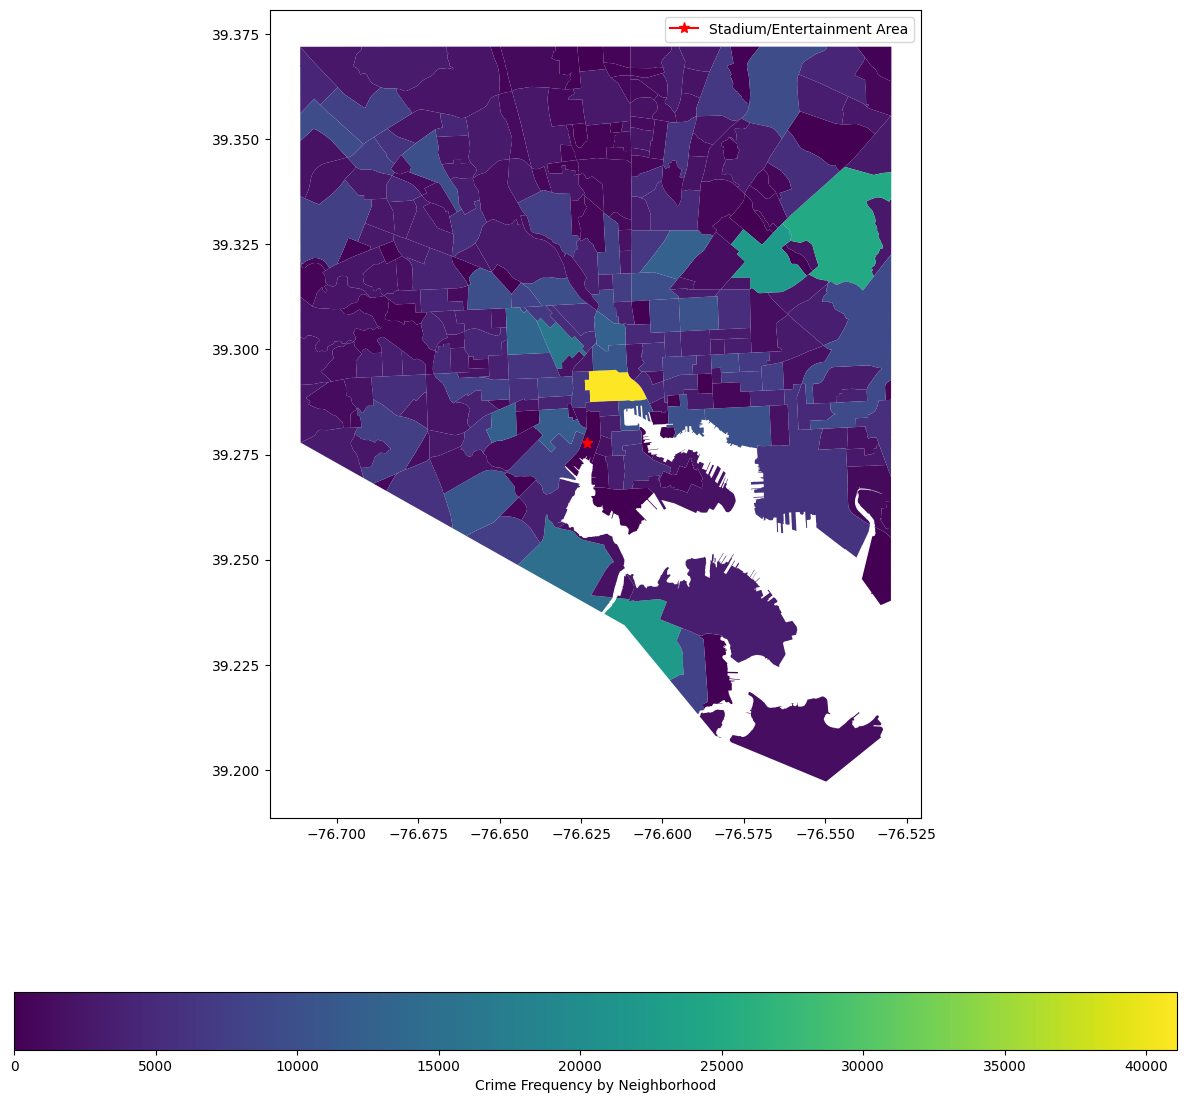

In [ ]:
# set the coordinate system of crime_counts_df to the latitude, longditude coordinates
baltimore_neighborhood_with_crime = crime_counts_df.set_crs(epsg=4326)

# get the geometry of the stadium area
stadium_geometry = baltimore_neighborhood_cleaned_gdf[baltimore_neighborhood_cleaned_gdf["Name"] == "Stadium/Entertainment Area"]["geometry"]

#plot Baltimore as a heatmap based on crime by neighborhood
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
baltimore_neighborhood_with_crime.plot(column='crime_count', ax=ax, legend=True,
                                       legend_kwds={'label': "Crime Frequency by Neighborhood",
                                                    'orientation': "horizontal"})

# get the center for where the stadium is
stadium_point = stadium_geometry.centroid

#plot the stadium on the map
ax.plot(stadium_point.x, stadium_point.y, marker='*', markersize=8, color="red", label='Stadium/Entertainment Area')
ax.legend(loc='upper right')

plt.show()

From the map, we can get a few takeaways:
*   Highest Crime Rate: From the map, visually it is clear that the neighborhood with the highest crime rate (which from previous analysis, we know to be Downtown) is very close to the Ravens stadium which could indicate that there is a correlation between crime and neighborhoods closer to the Ravens stadium.
*   Further away: We see that as we get further from the Ravens stadium more towards the outer ends of Baltimore, crime seems to be getting lower as we see that most of these neighborhoods are colored very dark blue.



## 4.2: Crime Over Time

### 4.2.1: Line Plot of Crime By Month

To get a general sense of crime throughout Baltimore during different times in the year, we wanted to visualize the average crime per week by month for each month in our dataset. This would just give us some basic intuition as to whether there is heightened crime at one point in the year, which can help with with our later analysis and modelling.

In [ ]:
#find the number of crimes that occured on each day and store it in
crimes_by_month_df = crime_cleaned_df.groupby('callDateTime').size().reset_index(name='crime_count')

#convert the "callDateTime" column into datetime objects and make them the index of the df
crimes_by_month_df['callDateTime'] = pd.to_datetime(crimes_by_month_df['callDateTime'])
crimes_by_month_df.set_index('callDateTime', inplace=True)

#aggregate the data by month and store the mean number of crimes in each month in the data
monthly_crime_df = crimes_by_month_df['crime_count'].resample('M').sum()
monthly_crime_df = monthly_crime_df.reset_index()

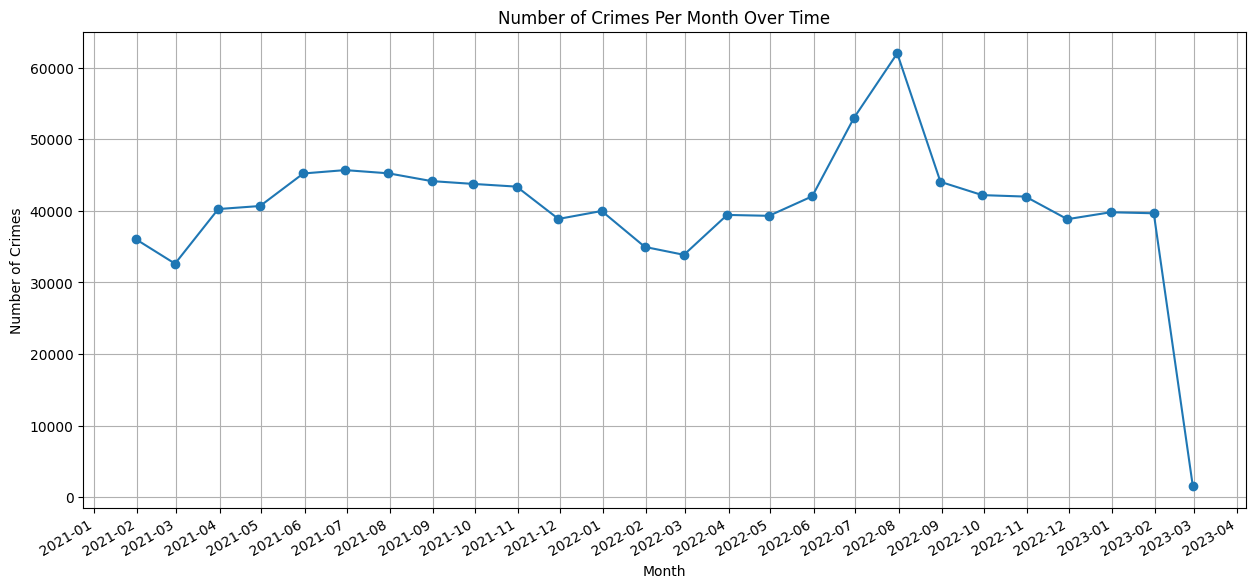

In [ ]:
#plot the month data as a line chart
plt.figure(figsize=(15, 7))
plt.plot(monthly_crime_df['callDateTime'], monthly_crime_df['crime_count'], marker='o')

plt.title('Number of Crimes Per Month Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.gcf().autofmt_xdate()

plt.show()

We can take a few things away from this chart:

*   August 2022: This month had a large spike with the most amount of crimes throughout the entire dataset. However, August of 2021 didn't have a similar spike. It appears, though, that crime throughout the timeframe of this data remained relatively constant, although there are a few dips.
*   March 2023: There is a major dip in this section, although this could be because the dataset stopped recording at this point, since there is such few reported crime in this month (nearly 0)



### 4.2.2: Box and Whisker Plot of Crime By Month By Neighborhood

Next, we wanted to compare each month to the mean, along with a 3 quarter breakdown, to see how much the data in each month deviated from the average amount of crime per month. This could help us intuitevely visualize which months had higher rates of crime. To do this, we will utilize a box and whisker plot of each month.

In [ ]:
# add a column to the df that stores the month as a number
crimes_by_month_df ["Month"] = crimes_by_month_df.index.month

<Figure size 1000x600 with 0 Axes>

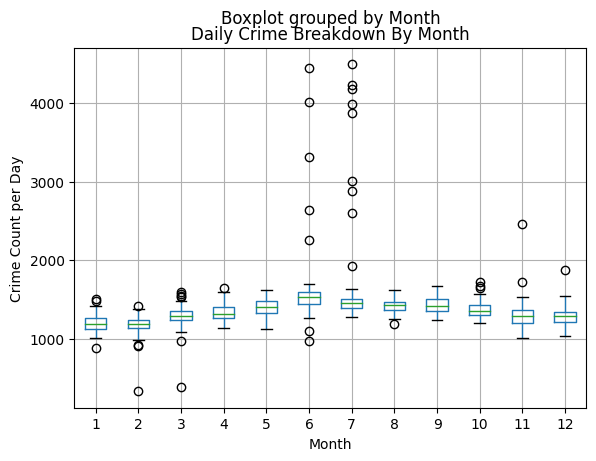

In [ ]:
#build the boxplot
plt.figure(figsize=(10, 6))
crimes_by_month_df.boxplot(column = "crime_count", by = "Month")
plt.title ("Daily Crime Breakdown By Month")
plt.ylabel("Crime Count per Day")
plt.show()

We can take a few things away from this chart

*   June and July: In general, it appears as though June and July have many outliers compared to the rest of the months. This means that there were some days in June/July that had very high crime rates compared to the mean during those months. Note that the means for those months were also fairly high, which could be an indication that there was high crime during these months
*   Start/End of the year: the averages at the start and end of the year for crime on each day were fairly low compared to the other months. The graph slowly rises as then falls back down from the start to the end of the year.



## 4.3: Crime During Ravens Games/Season

### 4.3.1: Bar Chart of Average Crime Per Day on Game Days vs. Non Game Days Within the Season



Next, we wanted to look at if there was a significant difference between average crime on game days vs. non game days. This would help us determine if the Ravens having a home game was a driving factor of crime in Baltimore. This was broken down during the season.

To do this, we created a histogram that compares the average crime in Baltimore on game days vs. non game days.

In [ ]:
# create a new df that stores the number of crimes that occurred each day during the season
crime_counts_during_season_df = crime_during_season_df.groupby('callDateTime').size().reset_index(name='crime_count_by_day')

# calculate the average crime count during the season per day
average_crime_count = crime_counts_during_season_df['crime_count_by_day'].mean()

In [ ]:
# create a df that keeps only crime that occurred on home games.
home_games_df = crime_on_game_days_df[crime_on_game_days_df['Venue'] == 1]
home_games_df = home_games_df.groupby('callDateTime').size().reset_index(name='crime_count_by_day')
average_game_day_crime_count = home_games_df['crime_count_by_day'].mean()

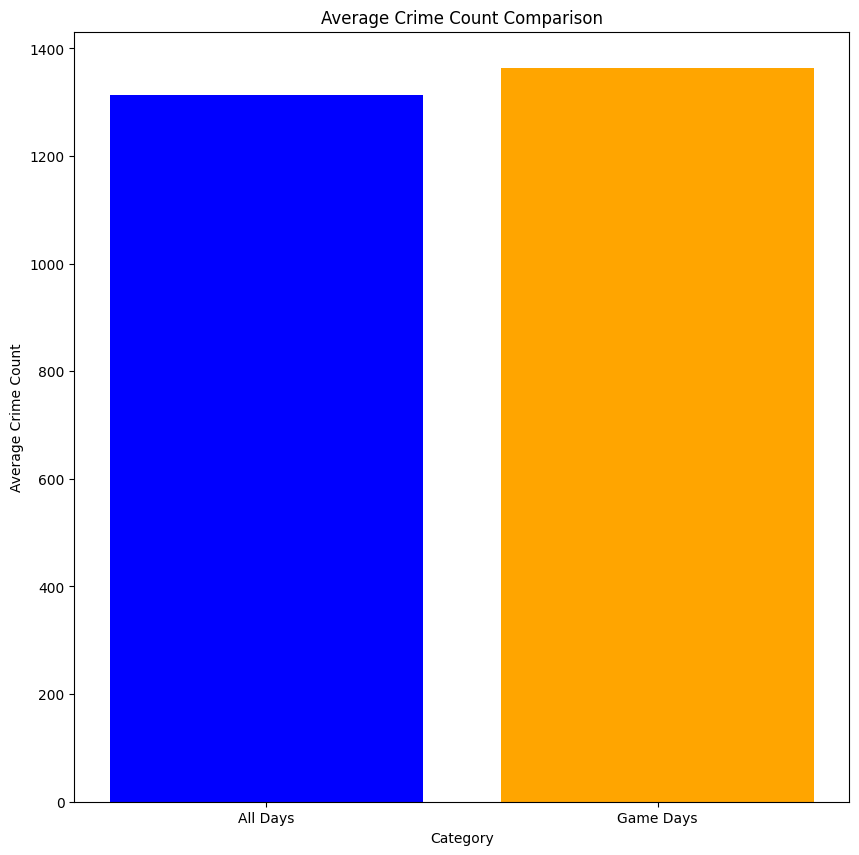

In [ ]:
categories = ['All Days', 'Game Days']

# Values corresponding to each category
values = [average_crime_count, average_game_day_crime_count]

# Create a bar chart
plt.figure(figsize=(10, 10))
plt.bar(categories, values, color=['blue', 'orange'])

# Add a title and labels
plt.title('Average Crime Count Comparison')
plt.xlabel('Category')
plt.ylabel('Average Crime Count')

# Show the plot
plt.show()

We can take somethings away from this chart:
*   It is clear that there is a slightly higher average crime rate on game days (approx 50). This isn't a very large difference so it is hard to conclude if it being a game day does have an effect on crime.


### 4.3.2: Map of Crime On Home Game Days By Neighborhood


We wanted to now investigate, geographically, if we notice a shift in crime specifically on game days. To do this, we build a heat map to show the crime by neighborhood specifically on game days.

In [ ]:
# group the crimes during the season by neighborhood and date to get the count per neighborhood by day
daily_crimes = crime_during_season_df.groupby(['callDateTime', 'Neighborhood']).size().reset_index(name='crime_count')

# get the average count per day
neighborhood_crime_avg = daily_crimes.groupby('Neighborhood')['crime_count'].mean().reset_index(name='average_crimes_per_day')

In [ ]:
# group to get daily crime count by neighborhood on game days
daily_crimes_gameday = crime_on_game_days_df.groupby(['callDateTime', 'Neighborhood']).size().reset_index(name='crime_count')
neighborhood_gameday_crime_avg = daily_crimes_gameday.groupby('Neighborhood')['crime_count'].mean().reset_index(name='average_gameday_crimes_per_day')
neighborhood_merged_df = neighborhood_gameday_crime_avg.merge(neighborhood_crime_avg, left_on="Neighborhood", right_on="Neighborhood", how="right")
neighborhood_merged_df["Difference"] = neighborhood_merged_df['average_gameday_crimes_per_day'] - neighborhood_merged_df["average_crimes_per_day"]
neighborhood_merged_df = neighborhood_merged_df[["Neighborhood", "Difference"]]
neighborhood_merged_df = neighborhood_merged_df.merge(baltimore_neighborhood_cleaned_gdf, left_on="Neighborhood", right_on="Name", how="left")
neighborhood_merged_df

,Neighborhood,Difference,Name,Population,White,Blk_AfAm,AmInd_AkNa,Asian,NatHaw_Pac,Other_Race,TwoOrMore,Hisp_Lat,Housing,Occupied,Vacant,geometry,Distance
0,Abell,-0.130960,Abell,975.0,632.0,169.0,0.0,73.0,0.0,11.0,90.0,52.0,503.0,453.0,50.0,"POLYGON Z ((-76.61113 39.32344 0.00000, -76.61...",0.038563
1,Allendale,0.225232,Allendale,3354.0,43.0,3209.0,10.0,5.0,1.0,30.0,56.0,39.0,1719.0,1417.0,302.0,"POLYGON Z ((-76.67268 39.29333 0.00000, -76.67...",0.045820
2,Arcadia,-0.308802,Arcadia,1077.0,534.0,436.0,5.0,13.0,0.0,19.0,70.0,65.0,477.0,441.0,36.0,"POLYGON Z ((-76.57144 39.33808 0.00000, -76.57...",0.067314
3,Arlington,0.019608,Arlington,2163.0,52.0,1991.0,6.0,26.0,2.0,13.0,73.0,42.0,1281.0,1050.0,231.0,"POLYGON Z ((-76.68626 39.34790 0.00000, -76.68...",0.082669
4,Armistead Gardens,0.447870,Armistead Gardens,3779.0,1763.0,158.0,32.0,41.0,2.0,1282.0,501.0,1911.0,1533.0,1402.0,131.0,"POLYGON Z ((-76.54926 39.31532 0.00000, -76.54...",0.062149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,Wrenlane,0.132132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
274,Wyman Park,0.132035,Wyman Park,1120.0,893.0,29.0,0.0,88.0,0.0,15.0,95.0,44.0,584.0,536.0,48.0,"POLYGON Z ((-76.62594 39.33113 0.00000, -76.62...",0.040897
275,Wyndhurst,0.077670,Wyndhurst,680.0,572.0,35.0,1.0,27.0,0.0,11.0,34.0,23.0,321.0,315.0,6.0,"POLYGON Z ((-76.62365 39.35385 0.00000, -76.62...",0.068251
276,Yale Heights,0.579248,Yale Heights,2527.0,151.0,2198.0,7.0,45.0,0.0,23.0,103.0,71.0,1141.0,1055.0,86.0,"POLYGON Z ((-76.69393 39.27962 0.00000, -76.69...",0.053493


<ipython-input-44-834f477b653e>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stadium_point = stadium_geometry.centroid


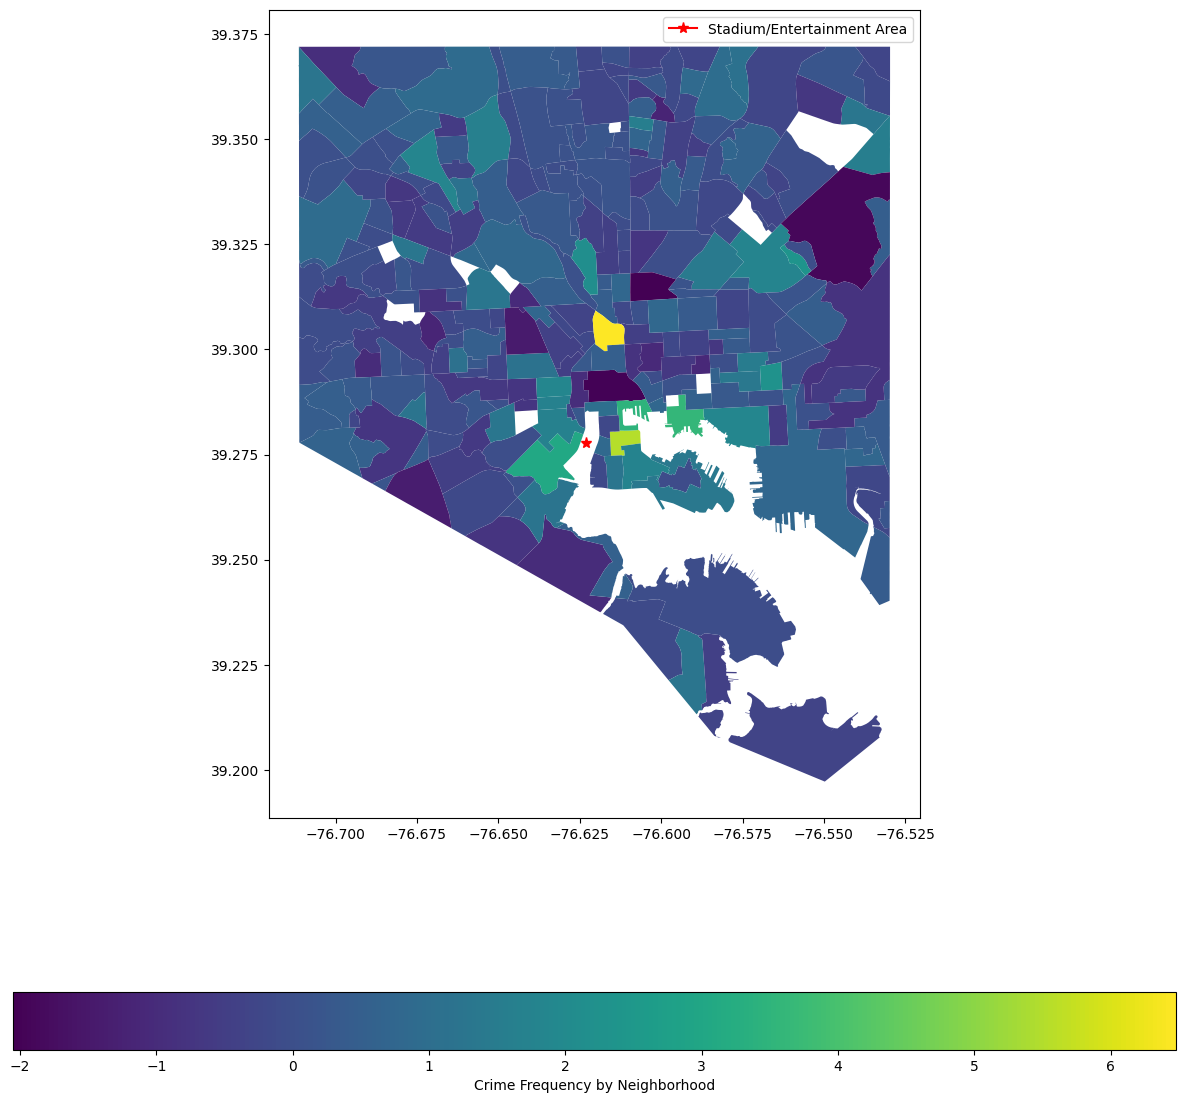

In [ ]:
neighborhood_merged_with_crime = gpd.GeoDataFrame(neighborhood_merged_df, geometry='geometry')
neighborhood_merged_with_crime = neighborhood_merged_with_crime.set_crs(epsg=4326)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
neighborhood_merged_with_crime.plot(column='Difference', ax=ax, legend=True,
                                       legend_kwds={'label': "Crime Frequency by Neighborhood",
                                                    'orientation': "horizontal"})
stadium_point = stadium_geometry.centroid

ax.plot(stadium_point.x, stadium_point.y, marker='*', markersize=8, color="red", label='Stadium/Entertainment Area')
ax.legend(loc='upper right')

plt.show()

We can take a few things away from this map:
*   Overall, there is a difference between game days and non game days in terms of crime rates in Baltimore, as mostly all of the neighborhoods are colored
*   This definitely also does seem exacerbated directly around the stadium, with many greener neighborhoods there


